## IS453 Financial Analytics
## Week 9 - Credit Scoring Lab

### Data Preparation and Logistic Regression

## HMEQ Dataset

The data set HMEQ reports characteristics and delinquency information for 5,960 home equity loans. A home equity loan is a loan where the obligor uses the equity of his or her home as the underlying collateral. 
The data is originally taken from the Credit Risk Analytics: Measurement Techniques, Applications, and Examples in SAS book website - https://www.bartbaesens.com/book/6/credit-risk-analytics.
A cleaner version of the data is on Kaggle - https://www.kaggle.com/akhil14shukla/loan-defaulter-prediction/data


**Variables definition**

1. BAD: Binary response variable
    - 1 = applicant defaulted on loan or seriously delinquent; 
    - 0 = applicant paid loan or customer is current on loan payments. This is the class column.
2. LOAN: Requested loan amount
3. MORTDUE: Amount due on existing mortgage
4. VALUE: Value of current property
5. REASON: 
    - DebtCon = debt consolidation(customer uses home equity loan to pay back high interest loans)
    - HomeImp = home improvement
6. JOB: Occupational categories
    - ProfExe
    - Mgr
    - Office
    - Self
    - Sales
    - Other
7. YOJ: Years at present job
8. DEROG: Number of major derogatory reports(issued for loans taken in the past when customer fails to keep up the contract or payback on time).
9. DELINQ: Number of delinquent credit lines
10. CLAGE: Age of oldest credit line in months
11. NINQ: Number of recent credit inquiries
12. CLNO: Number of credit lines
13. DEBTINC: Debt-to-income ratio in percent

In [28]:
# sample code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [29]:

# sample code

hmeq_data = pd.read_csv('hmeq_data.csv')

# make a copy of the original data for reference
hmeq_data_orig = hmeq_data.copy()

hmeq_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


## 1. Data preparation

Because we are going to test using logistic regression as a predictive model, we cannot have any missing values in the data. So will remove any rows with missing values. 

This would NOT be a good thing to do in practice.

In [30]:
# sample code
# note: when you run this cell, hmeq_data will be changed

# drop rows based on a threshold value of at 1 or more missing values
rows_org = hmeq_data.shape[0]
print(f'Starting row count: {rows_org:,.0f}')

# drop rows based on a threshold of 1 or more missing values per row
hmeq_data = hmeq_data.dropna(thresh = hmeq_data.shape[1] - 0)
print(f'Ending row count: {hmeq_data.shape[0]:,.0f}')
print(f'Percent dropped: {(1 - hmeq_data.shape[0] / rows_org):.2%}')

Starting row count: 5,960
Ending row count: 3,364
Percent dropped: 43.56%


Check the value counts for all the fields, should be the same now.

In [31]:
hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3364 entries, 5 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3364 non-null   int64  
 1   LOAN     3364 non-null   int64  
 2   MORTDUE  3364 non-null   float64
 3   VALUE    3364 non-null   float64
 4   REASON   3364 non-null   object 
 5   JOB      3364 non-null   object 
 6   YOJ      3364 non-null   float64
 7   DEROG    3364 non-null   float64
 8   DELINQ   3364 non-null   float64
 9   CLAGE    3364 non-null   float64
 10  NINQ     3364 non-null   float64
 11  CLNO     3364 non-null   float64
 12  DEBTINC  3364 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 367.9+ KB


**Remove categorical variables**

Because we are going to test using logistic regression as a predictive model, we cannot include categorical values in the data. So will remove the categorical data columns.

This would NOT be a good thing to do in practice.

In [32]:
# sample code
hmeq_data = hmeq_data.drop(['REASON','JOB'], axis = 1)
hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3364 entries, 5 to 5959
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3364 non-null   int64  
 1   LOAN     3364 non-null   int64  
 2   MORTDUE  3364 non-null   float64
 3   VALUE    3364 non-null   float64
 4   YOJ      3364 non-null   float64
 5   DEROG    3364 non-null   float64
 6   DELINQ   3364 non-null   float64
 7   CLAGE    3364 non-null   float64
 8   NINQ     3364 non-null   float64
 9   CLNO     3364 non-null   float64
 10  DEBTINC  3364 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 315.4 KB


**Ex Q1:**

What some reasons why it would be bad to drop rows with missing values and categorical column values?

Your answer

It could eliminate important patterns, might fundamentally change the nature of the data (eg. wiping out half of the bads)

If categorical data is predictive but deleted, it might remove critical insights 

**Identify and drop invalid outliers**

Only remove the outliers that are impossible values.

In [33]:
# sample code 

# which maximum value looks impossible?
hmeq_data.select_dtypes('number').max().map('{:,.0f}'.format)

BAD              1
LOAN        89,900
MORTDUE    399,412
VALUE      512,650
YOJ             41
DEROG           10
DELINQ          10
CLAGE        1,168
NINQ            13
CLNO            64
DEBTINC        144
dtype: object

In [34]:
# sample code

# maximum reasonable CLAGE = 80 years * 12 months = 960 months
max_clage = 80 * 12

# find rows that exceed that threshold
hmeq_data[hmeq_data['CLAGE'] > max_clage]

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3679,1,19300,96454.0,157809.0,3.0,0.0,0.0,1168.233561,0.0,0.0,40.206138


In [35]:
# sample code

# check number of rows before, drop those rows, and then check after
print(hmeq_data.shape[0])
hmeq_data.drop(hmeq_data[hmeq_data['CLAGE'] > max_clage].index, inplace=True)
print(hmeq_data.shape[0])

3364
3363


**Ex Q2: check for highly correlated variables**

Including highly correlated variable in the input data will cause problems for the logistic regression model. 

Find variables have a correlation value of > 0.8 <BR>
Of those variables, drop the one with the lower correlation to BAD
- Which one did you drop?
- Why do we want to drop highly correlated variables?

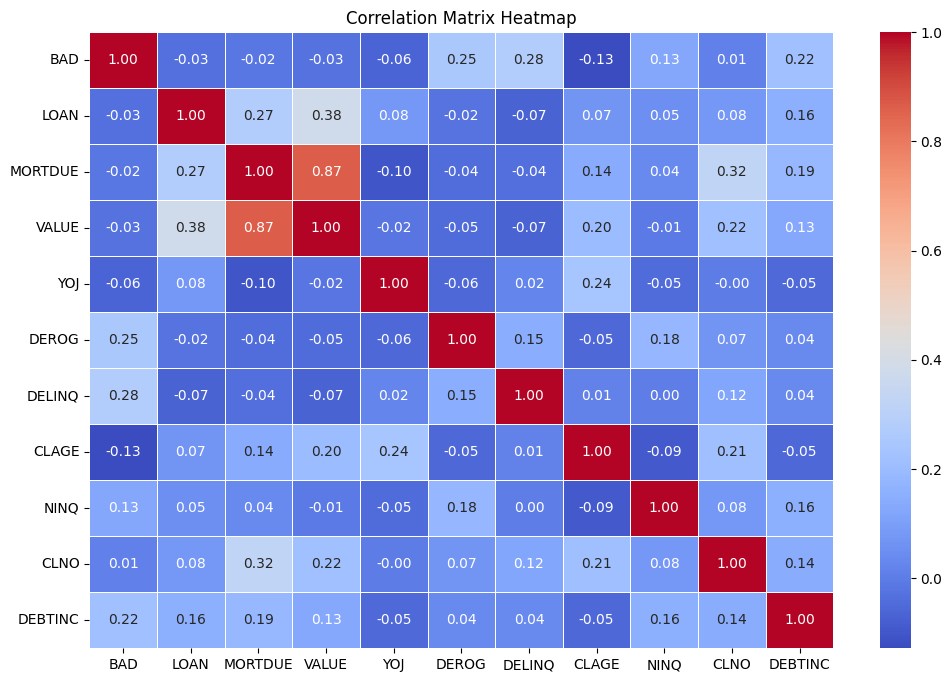

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3363 entries, 5 to 5959
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3363 non-null   int64  
 1   LOAN     3363 non-null   int64  
 2   MORTDUE  3363 non-null   float64
 3   VALUE    3363 non-null   float64
 4   YOJ      3363 non-null   float64
 5   DEROG    3363 non-null   float64
 6   DELINQ   3363 non-null   float64
 7   CLAGE    3363 non-null   float64
 8   NINQ     3363 non-null   float64
 9   CLNO     3363 non-null   float64
 10  DEBTINC  3363 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 315.3 KB


In [36]:
# your code here
plt.figure(figsize=(12, 8))
sns.heatmap(hmeq_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()
# check to see the remaining variables
hmeq_data.info()

In [37]:
# to drop
hmeq_data.drop(columns=['MORTDUE'], inplace=True)

hmeq_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3363 entries, 5 to 5959
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3363 non-null   int64  
 1   LOAN     3363 non-null   int64  
 2   VALUE    3363 non-null   float64
 3   YOJ      3363 non-null   float64
 4   DEROG    3363 non-null   float64
 5   DELINQ   3363 non-null   float64
 6   CLAGE    3363 non-null   float64
 7   NINQ     3363 non-null   float64
 8   CLNO     3363 non-null   float64
 9   DEBTINC  3363 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 289.0 KB


Your answer

variables with more than 0.8 - MORTDUE, VALUE 

drop MORTDUE - lower correlation of -0.02 vs -0.03 (VALUE)

drop highly correlated values due to multi collinearity 

## 2. Logistic Regression
Now we can apply a logistic regression model to the data.

#### Do a simple test of logistic regression on a subset of the data

Perform logistic regression on the LOAN variable

In [38]:
# sample code

# X are the independent variables, y is the dependent variable
X = hmeq_data[['LOAN']]
y = hmeq_data['BAD']

# create a logistic regression model and fit the training data
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)

# make it easlier to view the output coefficients
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])
pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())

Intercept    0.187572
LOAN        -0.000010
dtype: float64

Plot the regession sigmoid curve versus the data

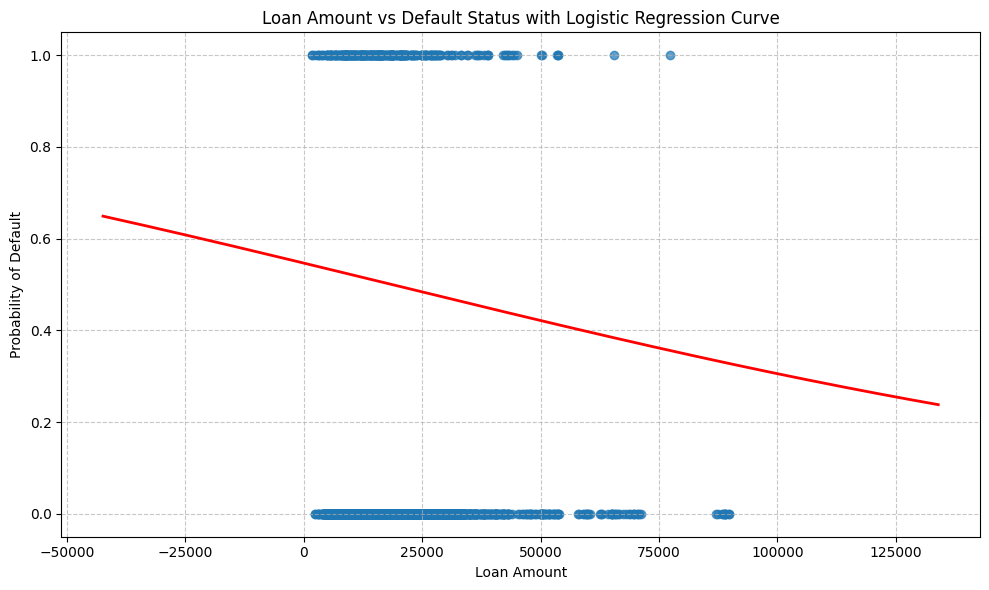

In [39]:
intercept = logreg.intercept_
loan_coef = logreg.coef_.reshape(-1)

# set figure size
plt.figure(figsize=(10, 6))

# create scatterplot
plt.scatter(hmeq_data['LOAN'], hmeq_data['BAD'], alpha=0.7)

# define sigmoid function
def sigmoid(x):
    z = intercept + loan_coef * x
    # to avoid numerical issues with large negative/positive values
    return np.exp(z) / (1 + np.exp(z))

# generate x values across a wider range to show the sigmoid shape
# using a much wider range than just the data range
x_min = hmeq_data['LOAN'].min()
x_max = hmeq_data['LOAN'].max()
x_range = np.linspace(x_min - 0.5 * (x_max - x_min), x_max + 0.5 * (x_max - x_min), 1000)

y_pred = sigmoid(x_range)

# plot the sigmoid curve
plt.plot(x_range, y_pred, 'r-', linewidth=2)

# add labels and title
plt.xlabel('Loan Amount')
plt.ylabel('Probability of Default')
plt.title('Loan Amount vs Default Status with Logistic Regression Curve')

# add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# show plot
plt.tight_layout()
plt.show()

**Ex Q3: perform logistic regression on the DELINQ variable**

Perform logistic regression on the DELINQ variable

In [40]:
# your code here
# sample code

# X are the independent variables, y is the dependent variable
X = hmeq_data[['DELINQ']]
y = hmeq_data['BAD']

# create a logistic regression model and fit the training data
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)

# make it easlier to view the output coefficients
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])
pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())

Intercept   -0.305329
DELINQ       0.657393
dtype: float64

Plot the regession versus the data

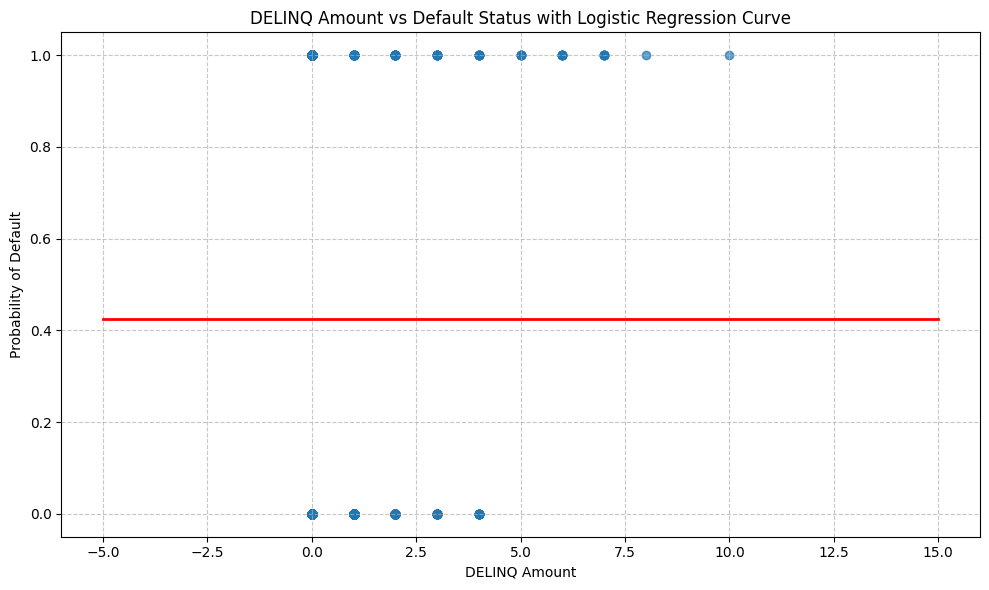

In [41]:
# your code here
intercept = logreg.intercept_
DELINQ_coef = logreg.coef_.reshape(-1)

# set figure size
plt.figure(figsize=(10, 6))

# create scatterplot
plt.scatter(hmeq_data['DELINQ'], hmeq_data['BAD'], alpha=0.7)

# define sigmoid function
def sigmoid(x):
    z = intercept + loan_coef * x
    # to avoid numerical issues with large negative/positive values
    return np.exp(z) / (1 + np.exp(z))

# generate x values across a wider range to show the sigmoid shape
# using a much wider range than just the data range
x_min = hmeq_data['DELINQ'].min()
x_max = hmeq_data['DELINQ'].max()
x_range = np.linspace(x_min - 0.5 * (x_max - x_min), x_max + 0.5 * (x_max - x_min), 1000)

y_pred = sigmoid(x_range)

# plot the sigmoid curve
plt.plot(x_range, y_pred, 'r-', linewidth=2)

# add labels and title
plt.xlabel('DELINQ Amount')
plt.ylabel('Probability of Default')
plt.title('DELINQ Amount vs Default Status with Logistic Regression Curve')

# add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# show plot
plt.tight_layout()
plt.show()

Ex Q3 questions to answer:
- Do increasing values raise or lower the probability of default for
    + LOAN
    + DELINQ
- Based on the regression, which variable do you think will be the better predictor? Why?

Your answer

- LOAN --> decrease
- DELINQ --> increase

DELINQ is the better predictor 
- from the shape (there is a clear point that indicates individuals will default) and the correlation of DELINQ is more correlated 

#### Do logistic regression using all of the variables


In [42]:
# sample code

# prepare data for logistic regression
X = hmeq_data.drop('BAD', axis = 1)
y = hmeq_data['BAD']

# create a logistic regression model and fit the training data
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X, y)

# concatenate intercept and coefficients to a single array
coeff = np.concatenate([logreg.intercept_, logreg.coef_.reshape(-1)])

# create a pandas Series with the features corresponding to the coefficients
coeff_series = pd.Series(coeff, index = ['Intercept'] + X.columns.tolist())
coeff_series


Intercept   -1.442904
LOAN        -0.000013
VALUE        0.000001
YOJ         -0.022933
DEROG        0.743007
DELINQ       0.755968
CLAGE       -0.005999
NINQ         0.134935
CLNO        -0.014175
DEBTINC      0.064492
dtype: float64

Calculate the probability of a new case being BAD using the logistic regression formula?:

![𝑃=1/(1+𝑒^(−(𝛽_0+𝛽_𝑖 𝑋_𝑖)))](<attachment:Screenshot 2025-03-13 at 10.26.12.png>)

New case values:
- LOAN = 1800
- VALUE = 40000
- YOJ = 9.5
- DEROG = 0
- DELINQ = 0
- CLAGE = 99
- NINQ = 1
- CLNO = 8
- DEBTINC = 38
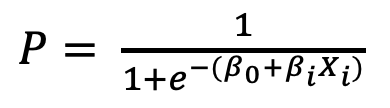

In [43]:
# sample code 

# define the data as a dictionary
data = {
    'LOAN': 1800,
    'VALUE': 40000,
    'YOJ': 9.5,
    'DEROG': 0,
    'DELINQ': 0,
    'CLAGE': 99,
    'NINQ': 1,
    'CLNO': 8,
    'DEBTINC': 38
}

# compute the exponent value 
# start with the intercept
linear_combination = coeff[0]
# add the product of each of coefficients and corresponding data values
for key in data.keys():
    linear_combination += coeff_series[key] * data[key]

# compute the probability using the logistic regression formula
probability = 1 / (1 + np.exp(-linear_combination))
pred_status = int(probability > 0.5)

print(f'probability = {probability:.3f}, predicted_status = {pred_status}')


probability = 0.561, predicted_status = 1


Alternatively, use the logreg functions to predict the probability and status

In [44]:
# create a dataframe to input to predict_proba
data_df = pd.DataFrame([data])

# use the logreg logreg functions to predict the probability and status
logreg_prob = logreg.predict_proba(data_df)[0][1]
logreg_pred_status = logreg.predict(data_df)
print(f'probability = {logreg_prob:.3f}, predicted_status = {logreg_pred_status[0]}')


probability = 0.561, predicted_status = 1


Calculate the the model's accuracy

In [45]:
# predict class labels
y_pred = logreg.predict(X)

# convert actual y values to array for comparison with predicted values
y_array = y.to_numpy() 

# compute accuracy
# first, calcuate how many predicted values match the actual values
correct_predictions = sum(y_pred[i] == y_array[i] for i in range(len(y)))

# then, calculate the accurate predictions as a percentage of the total
accuracy = correct_predictions / len(y)
print(f'Model accuracy: {accuracy:.4}')

Model accuracy: 0.7782


Alternatively, we can use the sklearn accuracy_score function to calculate accuracy

In [46]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y, y_pred)
print(f'Model accuracy: {accuracy:.4}')

Model accuracy: 0.7782


**DIY Q1:**

From the original hmeq_data data set, create a new data sets that include either the VALUE or the MORTDUE variable. 
- Is the model accuracy better or worse with one, the other, or both?

In [47]:
# your code here
hmeq_copy2 = hmeq_data_orig.copy()
# drop rows based on a threshold of more than 3 missing values per row 
hmeq_copy2.dropna(thresh=hmeq_copy2.shape[-1]-3, inplace=True)
#clean null values
hmeq_copy2['JOB'] = hmeq_copy2['JOB'].fillna(value = 'Missing')
hmeq_copy2['REASON'] = hmeq_copy2['REASON'].fillna(value = 'Missing')
#drop rows that exceed maximum reasonable CLAGE = 80 years * 12 months
max_clage = 80*12
hmeq_copy2.drop(hmeq_copy2[hmeq_copy2['CLAGE'] > max_clage].index, inplace =True)
#dummy variable encoding
hmeq_copy2 = pd.get_dummies(hmeq_copy2, columns = ['REASON'])
hmeq_copy2 = pd.get_dummies(hmeq_copy2, columns = ['JOB'])
#fill the n/a values with the median value for this example
numeric_cols = ['LOAN', 'YOJ','DELINQ','CLAGE','NINQ','CLNO','DEBTINC','MORTDUE','VALUE','DEROG']
medians = hmeq_copy2[numeric_cols].median()
hmeq_copy2.fillna(medians, inplace=True)
#drop VALUE column
hmeq_copy2.drop( columns = 'VALUE' , inplace= True)

#LR preparation
X= hmeq_copy2.drop('BAD', axis =1)
y= hmeq_copy2['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

#create the log reg model
logreg = LogisticRegression(solver='liblinear', class_weight = 'balanced' )
logreg.fit(X_train, y_train)

#Accuracy
y_pred = logreg.predict(X_test)
accuracy= accuracy_score(y_test, y_pred)
print(f'Testing accuracy AFTER dropping VALUE Column is {np.round(accuracy,3)}')


Testing accuracy AFTER dropping VALUE Column is 0.76


In [48]:
hmeq_copy3 = hmeq_data_orig.copy()
# drop rows based on a threshold of more than 3 missing values per row 
hmeq_copy3.dropna(thresh=hmeq_copy3.shape[-1]-3, inplace=True)
#clean null values
hmeq_copy3['JOB'] = hmeq_copy3['JOB'].fillna(value = 'Missing')
hmeq_copy3['REASON'] = hmeq_copy3['REASON'].fillna(value = 'Missing')
#drop rows that exceed maximum reasonable CLAGE = 80 years * 12 months
max_clage = 80*12
hmeq_copy3.drop(hmeq_copy3[hmeq_copy3['CLAGE'] > max_clage].index, inplace =True)
#dummy variable encoding
hmeq_copy3 = pd.get_dummies(hmeq_copy3, columns = ['REASON'])
hmeq_copy3 = pd.get_dummies(hmeq_copy3, columns = ['JOB'])
#fill the n/a values with the median value for this example
numeric_cols = ['LOAN', 'YOJ','DELINQ','CLAGE','NINQ','CLNO','DEBTINC','MORTDUE','VALUE','DEROG']
medians = hmeq_copy3[numeric_cols].median()
hmeq_copy3.fillna(medians, inplace=True)
#drop VALUE column
hmeq_copy3.drop( columns = 'MORTDUE' , inplace= True)

#LR preparation
X= hmeq_copy3.drop('BAD', axis =1)
y= hmeq_copy3['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

#create the log reg model
logreg = LogisticRegression(solver='liblinear', class_weight = 'balanced' )
logreg.fit(X_train, y_train)

#Accuracy
y_pred = logreg.predict(X_test)
accuracy= accuracy_score(y_test, y_pred)
print(f'Testing accuracy AFTER dropping MORTDUE Column is {np.round(accuracy,3)}')

Testing accuracy AFTER dropping MORTDUE Column is 0.757


Your answer 

they are almost the same, one at 0.76 and the other at 0.757

**DIY Q2:**

- Review the variables and identify two which you believe could be more useful when combined, as a ratio or difference, rather than as separate variables. Explain your reasoning for creating this extracted variable.
- From the original hmeq_data data set, add the extracted variable to the data set and remove the original two variables.  Calculate the accuracy of the module with the extracted variable and compare with the accuracy using the original two variables. Which is better?



In [49]:
# your code here

hmeq_data = hmeq_data_orig.copy()

hmeq_data.dropna(thresh =hmeq_data.shape[1]-3, inplace = True)

# fill the missing values for REASON with 'Missing'
hmeq_data['REASON'].fillna(value='Missing', inplace=True)
hmeq_data['JOB'].fillna(value='Missing', inplace=True)

#drop invalid outliers
max_clage = 80*12
hmeq_data.drop(hmeq_data[hmeq_data['CLAGE'] > max_clage].index, inplace=True)


#dummy variable encoding
hmeq_data = pd.get_dummies(hmeq_data, columns=['REASON'])
hmeq_data = pd.get_dummies(hmeq_data, columns=['JOB'])

#extract equity variable and drop VALUE and MORTDUE
hmeq_data['EQUITY'] = hmeq_data['VALUE'] - hmeq_data['MORTDUE']
hmeq_data.drop(['VALUE','MORTDUE'], axis='columns', inplace=True)

#fill the n/a values with the median value for this example
numeric_cols = ['LOAN', 'YOJ','DELINQ','CLAGE','NINQ','CLNO','DEBTINC','EQUITY','DEROG']
medians = hmeq_data[numeric_cols].median()
hmeq_data.fillna(medians, inplace=True)

#prepare data for logistic regression
X=hmeq_data.drop('BAD', axis=1)
y=hmeq_data['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

#create a logistic regression model and fit the training data
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)

#check the accuracy
y_pred = logreg.predict(X_test)
print(f'Testing accuracy with EQUITY and dropping VALUE and MORTDUE is {np.round(accuracy_score(y_test,y_pred), 4)}')

Testing accuracy with EQUITY and dropping VALUE and MORTDUE is 0.8025


Your answer 

the accuracy is higher after dropping VALUE and MORTDUE


**DIY Q3:**

To make the model and probability calculation simpler, we want to reduce the number of variables used by the model from 8 to 6. 

Determine which two variables will have the least impact on the predictive accuracy of the model, remove them and then calculate the how much the model's accuracy has changed. 

How did you determine which two variables to drop?

In [50]:
# your code here
# Load dataset
df = hmeq_data_orig.copy()

# Keep only the specified features
selected_features = ['LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'BAD']
df = df[selected_features]

#drop invalid outliers
max_clage = 80*12
hmeq_data.drop(hmeq_data[hmeq_data['CLAGE'] > max_clage].index, inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Target variable
y = df['BAD']  # Assuming 'BAD' is the binary target (1 = Default, 0 = No Default)
X_full = df.drop(columns=['BAD'])

# Function to train and evaluate model
def train_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred), model

# Train model with all 8 features
accuracy_full, model_full = train_evaluate(X_full, y)
print(f'Accuracy with all 8 features: {accuracy_full:.4f}')

# Get feature importance using absolute logistic regression coefficients
feature_importances = pd.Series(np.abs(model_full.coef_[0]), index=X_full.columns)

# Identify the two least important features
least_important = feature_importances.nsmallest(2).index.tolist()
print(f'Two least important features: {least_important}')

# Drop the two least important features
X_reduced = X_full.drop(columns=least_important)

# Train model with reduced feature set (6 features)
accuracy_reduced, _ = train_evaluate(X_reduced, y)
print(f'Accuracy with reduced 6 features: {accuracy_reduced:.4f}')

# Calculate accuracy change
accuracy_change = accuracy_full - accuracy_reduced
print(f'Change in accuracy after removing {least_important}: {accuracy_change:.4f}')

Accuracy with all 8 features: 0.9107
Two least important features: ['VALUE', 'LOAN']
Accuracy with reduced 6 features: 0.9134
Change in accuracy after removing ['VALUE', 'LOAN']: -0.0027


Your answer

- Variables removed: VALUE and LOAN
- Accuracy increased by: 0.0027
- How chose variables to drop: select the 2 features with smallest coefficients

# Group Assignment Preparation
Based on the group assignment data, answer the DYI question below.

**DYI Q4: Preparing the bureau data for merging**

To combine the buruau data with the application data you will need to "flatten" the multiple rows associated with each application ID (SK_ID_CURR) into a single row. <BR>
It will also be helpful if you can reduce the number of columns in the bureau data that will need to be merged.
- Based on the data dictionary defitions and the inspection of the bureau data, explain how you would propose to do feature engineering on all of the bureau variables so that they can be condensed to one value per application ID.
- Calculate the correlation between the bureau variables and use that information to further propose how columns could potentially be combined or dropped.

Put your code and answers below, and prepare to discuss in class next week.

In [51]:
# your code here

# Load bureau dataset
bureau = pd.read_csv('IS453 Group Assignment - Data/IS453 Group Assignment - Bureau Data.csv')

# Aggregating numerical variables
num_aggregations = {
    'DAYS_CREDIT': ['mean', 'min', 'max', 'count'],
    'CREDIT_DAY_OVERDUE': ['sum', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['mean'],
    'DAYS_ENDDATE_FACT': ['mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['sum', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'AMT_CREDIT_SUM': ['sum', 'mean'],
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean'],
    'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean'],
    'AMT_CREDIT_SUM_OVERDUE': ['sum'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'AMT_ANNUITY': ['mean']
}

# Aggregate numerical features
bureau_agg = bureau.groupby('SK_ID_CURR').agg(num_aggregations)

# Rename columns for clarity
bureau_agg.columns = ['_'.join(col).upper() for col in bureau_agg.columns]

# Encode categorical features
bureau_agg['CREDIT_ACTIVE_MODE'] = bureau.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].agg(lambda x: x.mode()[0])
bureau_agg['CREDIT_TYPE_MODE'] = bureau.groupby('SK_ID_CURR')['CREDIT_TYPE'].agg(lambda x: x.mode()[0])
bureau_agg['CREDIT_CURRENCY_MODE'] = bureau.groupby('SK_ID_CURR')['CREDIT_CURRENCY'].agg(lambda x: x.mode()[0])

# Reset index for merging
bureau_agg.reset_index(inplace=True)

# Save cleaned dataset
bureau_agg.to_csv("bureau_cleaned.csv", index=False)


In [52]:
application_data = pd.read_csv('IS453 Group Assignment - Data/IS453 Group Assignment - Application Data.csv')
final_data = application_data.merge(bureau_agg, on="SK_ID_CURR", how="left")
final_data.to_csv("merged_data.csv", index=False)

/var/folders/h9/5g6ckw5x34xcjvgtnjc382sc0000gn/T/ipykernel_16690/4288397655.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = bureau_agg.corr()


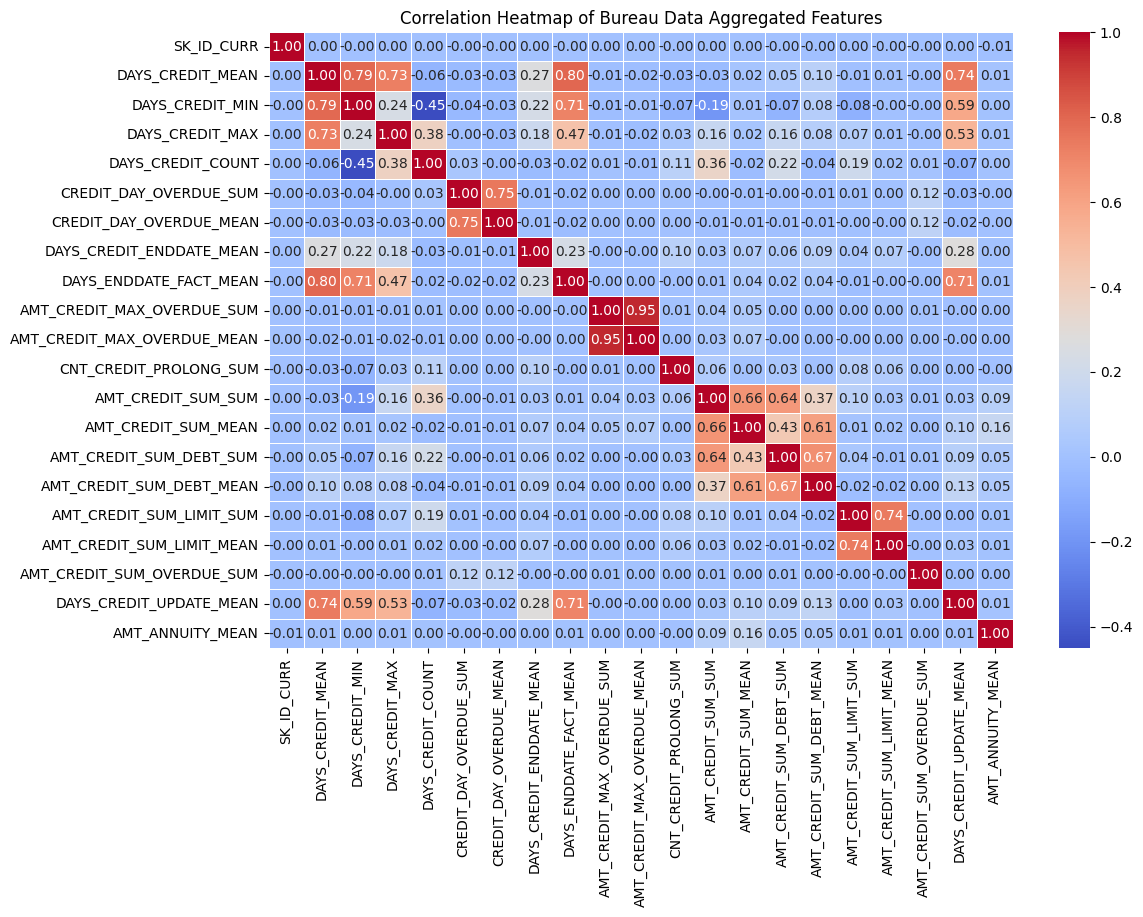

In [53]:
# Compute correlation matrix
corr_matrix = bureau_agg.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, linewidths=0.5, fmt='.2f')
plt.title("Correlation Heatmap of Bureau Data Aggregated Features")
plt.show()

Your answer 

we can drop variables with low correlations with BAD 

and drop highly correlated variables 